In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn import metrics
from datetime import datetime
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.utils import plot_model
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statistics import variance
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import cv
from sklearn.metrics import make_scorer
from sklearn.utils.fixes import loguniform

In [2]:
Apt_dataset=pd.read_csv("Apt_dataset.csv")

## Creating Training and Test Sets for the Apt dataset

In [3]:
X=Apt_dataset.drop(['List Price', 'Sold Price', 'Days on Market','Sale to List %','price class', 'log price'],axis=1)
Y=Apt_dataset[['Sold Price','log price',"price class"]]

In [4]:
from sklearn.preprocessing import StandardScaler
def X_norm(df):
    ndf=pd.DataFrame()
    for col in df.columns:
        #norm btw 0 and 1
        ndf[col]=df[col]/max(df[col])
    #Z_score for 'Taxes' and 'Maint. Fees'
    std_scaler = StandardScaler()
    ndf[['Taxes','Maint. Fees']] = std_scaler.fit_transform(ndf[['Taxes','Maint. Fees']].values.tolist())
    return ndf

nX=X_norm(X)
nY=Y.copy(deep=True)
_MAX_Y=max(Y['Sold Price'])
nY['Sold Price']=Y['Sold Price']/_MAX_Y

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(nX, nY, test_size=0.15,stratify=nY[["price class"]])

In [6]:
def error_summary(y_true, y_pred):
    MAPE=np.average(np.abs(y_true - y_pred) / y_true, axis=0)*100
    RMSE=np.sqrt(mean_squared_error(y_true, y_pred))
    R2=r2_score(y_true, y_pred)
    APE=np.abs(y_true - y_pred) / y_true
    acc=sum(APE<0.2)/len(APE)
    dict_error={'Value':[R2,_MAX_Y*RMSE,MAPE,acc]}
    index_error=['R2','RMSE','MAPE',"ACC(APE<20%)"]
    df = pd.DataFrame(dict_error,index=index_error)
    return round(df,2).T

def APE_hist(title,y_true, y_pred):
    APE=(np.abs(y_true - y_pred) / y_true)
    plt.hist(100*APE,bins=range(100),density=True,cumulative=True)
    plt.title(title)
    plt.xlabel('APE')
    plt.ylabel('cumulative distribution')
    
def GS_score(y, y_pred):
    ES=error_summary(y,y_pred)
    return ES["ACC(APE<20%)"].values

def Log_GS_score(y, y_pred):
    ES=error_summary(np.exp(y),np.exp(y_pred))
    return ES["ACC(APE<20%)"].values  

In [7]:
## RandomForest
# Grid serach with sold Price to find the best parameters

In [8]:
param_grid = { 
    'n_estimators': range(300,1001,100),
    'max_depth' : range(5,31,5),
    'bootstrap': [True, False]
    
}
ACC = make_scorer(GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=ACC,
                             n_jobs = -1)
rf_opt = rf_tune.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%): " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best ACC(APE<20%): 0.922

Optimal Model:
RandomForestRegressor(max_depth=15, n_estimators=400)

{'bootstrap': True, 'max_depth': 15, 'n_estimators': 400}


In [ ]:
# pick the smallest range from above parameters

In [10]:
param_grid = { 
    'n_estimators': range(350,451,10),
    'max_depth' : range(10,21)  
}
ACC = make_scorer(GS_score)
rfr=RandomForestRegressor(bootstrap=True)
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=ACC,
                             n_jobs = -1)

rf_opt = rf_tune.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%): " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best ACC(APE<20%): 0.922

Optimal Model:
RandomForestRegressor(max_depth=14, n_estimators=350)

{'max_depth': 14, 'n_estimators': 350}


In [16]:
# test the best parameters and plot it

In [41]:
rf_opt=RandomForestRegressor(bootstrap=True,max_depth=14,n_estimators=350).fit(X_train, Y_train['Sold Price'])

        R2      RMSE  MAPE  ACC(APE<20%)
Value  0.9  63324.59  8.76          0.92


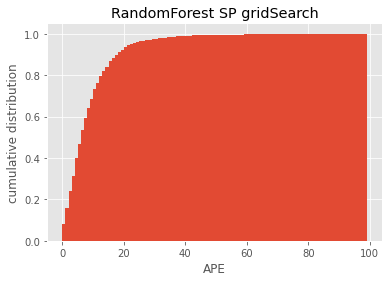

In [42]:
grid_predictions = rf_opt.predict(X_test)
print(error_summary(Y_test['Sold Price'],grid_predictions))
APE_hist("RandomForest SP gridSearch",Y_test['Sold Price'],grid_predictions)

In [ ]:
## Grid serach with Log price to find the best parameters

## RandomForest

In [14]:
param_grid = { 
    'n_estimators': range(300,1501,100),
    'max_depth' : range(5,41,5),    
}
ACC = make_scorer(Log_GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=ACC,
                             n_jobs = -1)
rf_opt = rf_tune.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%): " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best ACC(APE<20%): 0.924

Optimal Model:
RandomForestRegressor(max_depth=15, n_estimators=500)

{'max_depth': 15, 'n_estimators': 500}


Implement the GS algo with smallest range from above result

In [15]:
param_grid = { 
    'n_estimators': range(450,551,10),
    'max_depth' : range(10,21),
    
    
}
ACC = make_scorer(Log_GS_score)
rfr=RandomForestRegressor()
rf_tune =GridSearchCV(estimator=rfr, param_grid=param_grid,
                             cv = 5,
                             scoring=ACC,
                             n_jobs = -1)
rf_opt = rf_tune.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%): " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_) + "\n")
print(rf_opt.best_params_)

Best ACC(APE<20%): 0.9259999999999999

Optimal Model:
RandomForestRegressor(max_depth=20, n_estimators=490)

{'max_depth': 20, 'n_estimators': 490}


        R2      RMSE  MAPE  ACC(APE<20%)
Value  0.9  62182.97  8.34          0.94


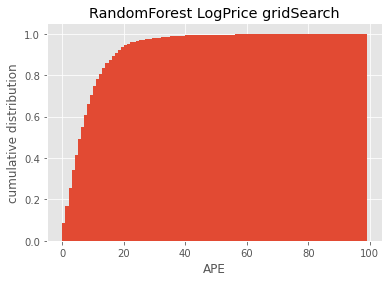

In [18]:
grid_predictions = np.exp(rf_opt.predict(X_test))/_MAX_Y
print(error_summary(Y_test['Sold Price'],grid_predictions))
APE_hist("RandomForest LogPrice gridSearch",Y_test['Sold Price'],grid_predictions)

In [ ]:
## RandomForestRegressor-K_Fold for the sold price {max_depth': 14, 'n_estimators': 350}

In [19]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    rfr=RandomForestRegressor(n_estimators=350,
                              max_depth=14,
                              bootstrap=True).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['Sold Price'])
                                
    y_pred=rfr.predict(nX.iloc[test_index])
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values)
    
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.898(0.018)
RMSE=62228(5137)
MAPE=8.577(0.481)
ACC(APE<20%)=0.924(0.012)


In [ ]:
## K-Fold for Log Price 'bootstrap': True, 'max_depth': 20, 'n_estimators': 490

In [20]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    rfr=RandomForestRegressor(n_estimators=490,
                              max_depth=20,
                              bootstrap=True).fit(nX.iloc[train_index],
                                                  nY.iloc[train_index]['log price'])
                                
    y_pred=np.exp(rfr.predict(nX.iloc[test_index]))/_MAX_Y
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values)
    
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.9(0.018)
RMSE=61473(5347)
MAPE=8.173(0.458)
ACC(APE<20%)=0.93(0.012)


## XGBoost

In [27]:
parameters = {'n_estimators': range(100,700,50), 'max_depth':range(5,51,5)}
XGB_base =xgb.XGBRegressor()
ACC = make_scorer(GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=ACC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%):" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.944

{'max_depth': 5, 'n_estimators': 400}


In [28]:
parameters = {'n_estimators': range(350,451,10), 'max_depth':range(3,10)}
XGB_base =xgb.XGBRegressor()
ACC = make_scorer(GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=ACC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%):" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.944

{'max_depth': 5, 'n_estimators': 400}


         R2     RMSE  MAPE  ACC(APE<20%)
Value  0.92  56093.1  7.41          0.95


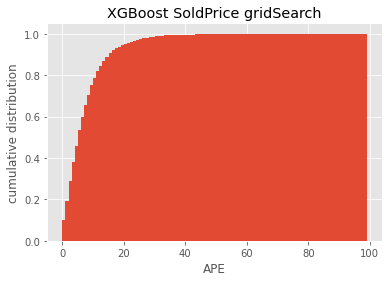

In [29]:
grid_predictions = XGB_opt.predict(X_test)
print(error_summary(Y_test['Sold Price'],grid_predictions))
APE_hist("XGBoost SoldPrice gridSearch",Y_test['Sold Price'],grid_predictions)

## XGBOOST

In [31]:
parameters = {'n_estimators': range(100,701,50), 'max_depth':range(3,51,5)}
XGB_base =xgb.XGBRegressor()
ACC = make_scorer(Log_GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 5,
                         scoring=ACC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%):" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.944

{'max_depth': 3, 'n_estimators': 600}


In [32]:
parameters = {'n_estimators': range(550,751,10), 'max_depth':range(2,10)}
XGB_base =xgb.XGBRegressor()
ACC = make_scorer(Log_GS_score)
XGB_tuned = GridSearchCV(XGB_base, parameters,
                         cv = 10,
                         scoring=ACC,
                         n_jobs = -1)

XGB_opt =XGB_tuned.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%):" + str(XGB_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(XGB_opt.best_estimator_) + "\n")
print(XGB_opt.best_params_)

Best ACC(APE<20%):0.9509999999999998

{'max_depth': 4, 'n_estimators': 700}


In [46]:
XGB_opt=xgb.XGBRegressor(max_depth=4,n_estimators=700).fit(X_train, Y_train['log price'])

         R2      RMSE  MAPE  ACC(APE<20%)
Value  0.92  55588.83  7.25          0.95


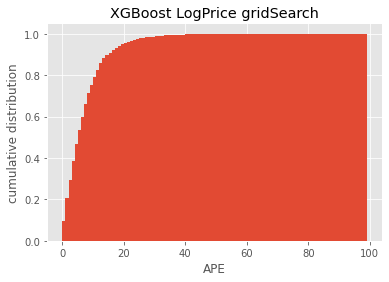

In [47]:
grid_predictions = np.exp(XGB_opt.predict(X_test))/_MAX_Y
print(error_summary(Y_test['Sold Price'],grid_predictions))
APE_hist("XGBoost LogPrice gridSearch",Y_test['Sold Price'],grid_predictions)

In [ ]:
#k-fold for sold price(XGBoost)'max_depth': 5, 'n_estimators': 400

In [30]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    XGBoost=xgb.XGBRegressor(n_estimators=400,
                             max_depth=5).fit(nX.iloc[train_index],
                                               nY.iloc[train_index]['Sold Price'])
    
    y_pred=XGBoost.predict(nX.iloc[test_index])
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values)
    
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.919(0.014)
RMSE=55445(4480)
MAPE=7.356(0.393)
ACC(APE<20%)=0.948(0.013)


In [ ]:
#k-fold for log price

In [34]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    XGBoost=xgb.XGBRegressor(n_estimators=700,
                             max_depth=4).fit(nX.iloc[train_index],
                                               nY.iloc[train_index]['log price'])
    
    y_pred=np.exp(XGBoost.predict(nX.iloc[test_index]))/_MAX_Y
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)  
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values)
    
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.922(0.015)
RMSE=54114(4833)
MAPE=7.084(0.363)
ACC(APE<20%)=0.953(0.01)


In [ ]:
## SVR model with parameters 'kernel':('linear','poly','rbf'), 'C':range(1,30) in grid search

In [35]:
parameters = {'kernel':('linear','poly','rbf'), 'C':range(1,30)}
SVR_base = SVR(degree=2) #defult()
ACC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.8140000000000001

{'C': 1, 'kernel': 'linear'}


In [ ]:
# Grid search 

In [36]:
parameters = {'kernel':('linear','poly','rbf'), 'C':range(30,60)}
SVR_base = SVR(degree=2) #defult()
ACC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.8140000000000001

{'C': 30, 'kernel': 'linear'}


In [39]:
parameters = {'C':[0.1*x for x in range(5,20)],'epsilon':[0.01*x for x in range(5,20)]}
SVR_base = SVR(kernel='linear')#defult()
ACC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.874

{'C': 0.5, 'epsilon': 0.05}


In [40]:
parameters = {'C':[0.1*x for x in range(1,6)],'epsilon':[0.01*x for x in range(1,6)]}
SVR_base = SVR(kernel='linear')#defult()
ACC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.8939999999999999

{'C': 0.1, 'epsilon': 0.01}


In [43]:
parameters = {'C':[0.02*x for x in range(1,6)],'epsilon':[0.002*x for x in range(1,6)]}
SVR_base = SVR(kernel='linear')#defult()
ACC = make_scorer(GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.8939999999999999

{'C': 0.02, 'epsilon': 0.002}


         R2      RMSE  MAPE  ACC(APE<20%)
Value  0.86  72158.66  9.96           0.9


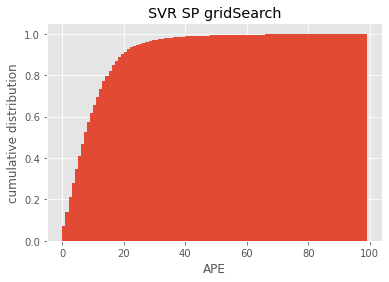

In [44]:
grid_predictions = SVR_opt.predict(X_test)
print(error_summary(Y_test['Sold Price'],grid_predictions))

APE_hist("SVR SP gridSearch",Y_test['Sold Price'],grid_predictions)

In [ ]:
#log price c 

In [45]:
parameters = {'kernel':('linear','poly','rbf'), 'C':range(1,30)}
SVR_base = SVR(degree=2) #defult()
ACC = make_scorer(Log_GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)
                                
SVR_opt =SVR_tuned.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best zero-one score: 0.9200000000000002

{'C': 1, 'kernel': 'rbf'}


In [48]:
parameters = {'C':[0.1*x for x in range(5,20)],'epsilon':[0.01*x for x in range(5,20)]}
SVR_base = SVR(kernel='rbf')#defult()
ACC = make_scorer(Log_GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.922

{'C': 0.5, 'epsilon': 0.05}


In [49]:
parameters = {'C':[0.1*x for x in range(1,6)],'epsilon':[0.01*x for x in range(1,6)]}
SVR_base = SVR(kernel='rbf')#defult()
ACC = make_scorer(Log_GS_score)
SVR_tuned = GridSearchCV(estimator=SVR_base, param_grid=parameters,
                         cv = 5,scoring=ACC,n_jobs = -1)

SVR_opt =SVR_tuned.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%: " + str(SVR_opt.best_score_) + "\n")
#print("Optimal Model:\n" + str(SVR_opt.best_estimator_) + "\n")
print(SVR_opt.best_params_)

Best ACC(APE<20%: 0.922

{'C': 0.4, 'epsilon': 0.01}


         R2      RMSE  MAPE  ACC(APE<20%)
Value  0.89  64759.04  8.84          0.92


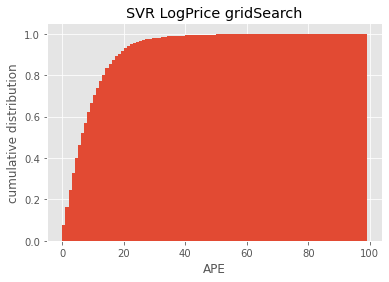

In [50]:
grid_predictions = np.exp(SVR_opt.predict(X_test))/_MAX_Y
print(error_summary(Y_test['Sold Price'],grid_predictions))

APE_hist("SVR LogPrice gridSearch",Y_test['Sold Price'],grid_predictions)

In [ ]:
#k-fold for svr (sold price)

In [52]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    SVRegressor=SVR(kernel='linear', C=0.01,epsilon=0.001).fit(nX.iloc[train_index],
                                            nY.iloc[train_index]['Sold Price'])
    
    y_pred=SVRegressor.predict(nX.iloc[test_index])
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values)
    
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.865(0.021)
RMSE=71633(6316)
MAPE=9.936(0.515)
ACC(APE<20%)=0.896(0.017)


In [ ]:
#K-FOLD FOR SVR LOG PRICE

In [54]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    SVRegressor=SVR(kernel='rbf', C=0.4,epsilon=0.01).fit(nX.iloc[train_index],
                                            nY.iloc[train_index]['log price'])
    
    y_pred=np.exp(SVRegressor.predict(nX.iloc[test_index]))/_MAX_Y
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values)
    
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.894(0.018)
RMSE=63157(5339)
MAPE=8.653(0.429)
ACC(APE<20%)=0.924(0.013)
